# MCMC algorithms, sampling problems/sampling techniques, Bayesian data analysis 

## Metropolis-Hastings



This post includes code and notes from : https://www.tweag.io/blog/2019-10-25-mcmc-intro1/

+ https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

+ https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

In [58]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

In [59]:
state_space = ("sunny", "cloudy", "rainy")

In [60]:
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

In [61]:
n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

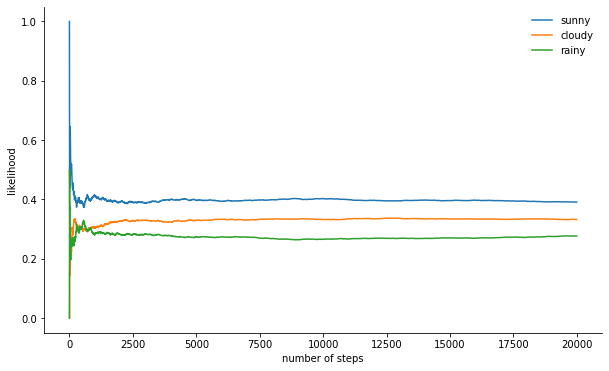

In [62]:
def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("likelihood")
ax.legend(frameon=False)
despine(ax, ('top', 'right'))
plt.show()

In [63]:
def log_prob(x):
     return -0.5 * np.sum(x ** 2)

In [64]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize,
                             high=x + 0.5 * stepsize,
                             size=x.shape)

In [65]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

In [66]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether we accept the new state or not:
    # we draw a random number uniformly from [0,1] and compare
    # it with the acceptance probability
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

In [67]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept 

    acceptance_rate = n_accepted / float(n_total)

    return chain, acceptance_rate

In [68]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)

In [69]:
chain = [state for state, in chain]

In [70]:
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state)
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: 0.720
Last ten states of chain: 1.05847, 1.59966, 0.14389, -1.13281, 0.24131, -0.77448, -0.59703, 0.67707, 1.47065, 1.27361


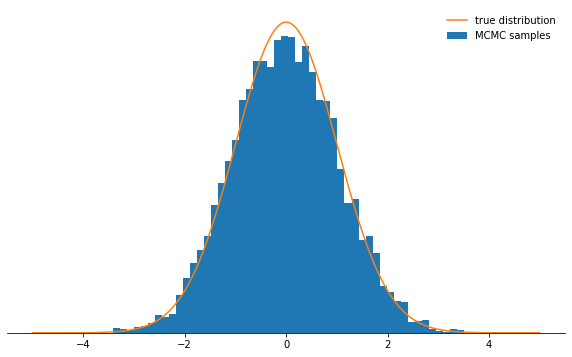

In [71]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    
    from scipy.integrate import quad

    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)

fig, ax = plt.subplots()
plot_samples(chain[500:], log_prob, ax)
despine(ax)
ax.set_yticks(())
plt.show()

Acceptance rate: 0.104


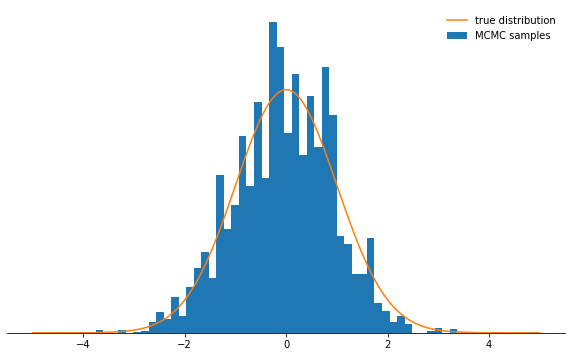

In [72]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    despine(ax)
    ax.set_yticks(())
    plt.show()

sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

Acceptance rate: 0.985


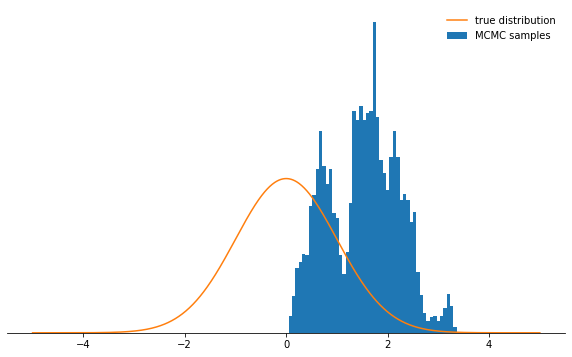

In [73]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)

Acceptance rate: 0.990


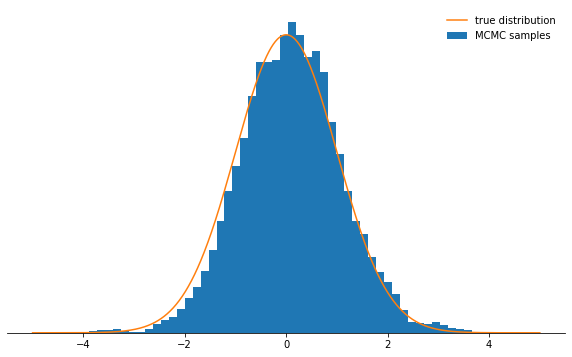

In [74]:
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)

In [75]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

np.random.seed(42)

def log_gaussian(x, mu, sigma):
    # The np.sum() is for compatibility with sample_MH
    return - 0.5 * np.sum((x - mu) ** 2) / sigma ** 2 \
           - np.log(np.sqrt(2 * np.pi * sigma ** 2))


class BivariateNormal(object):
    n_variates = 2
    
    def __init__(self, mu1, mu2, sigma1, sigma2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2
        
    def log_p_x(self, x):
        return log_gaussian(x, self.mu1, self.sigma1)
        
    def log_p_y(self, x):
        return log_gaussian(x, self.mu2, self.sigma2)
    
    def log_prob(self, x):        
        cov_matrix = np.array([[self.sigma1 ** 2, 0],
                               [0, self.sigma2 ** 2]])
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        kernel = -0.5 * (x - self.mu1) @ inv_cov_matrix @ (x - self.mu2).T
        normalization = np.log(np.sqrt((2 * np.pi) ** self.n_variates * np.linalg.det(cov_matrix)))
        
        return kernel - normalization               

    
bivariate_normal = BivariateNormal(mu1=0.0, mu2=0.0, sigma1=1.0, sigma2=0.15)

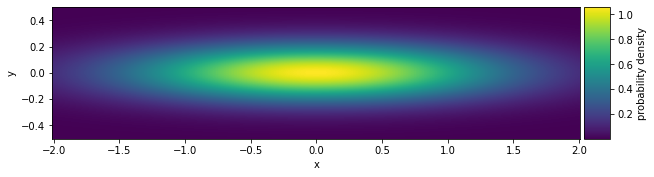

In [76]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
xses = np.linspace(-2, 2, 200)
yses = np.linspace(-0.5, 0.5, 200)
log_density_values = [[bivariate_normal.log_prob(np.array((x, y))) for x in xses] for y in yses]
dx = (xses[1] - xses[0]) / 2
dy = (yses[1] - yses[0]) / 2
extent = [xses[0] - dx, xses[-1] + dx, yses[0] - dy, yses[-1] + dy]
im = ax.imshow(np.exp(log_density_values), extent=extent)
ax.set_xlabel('x')
ax.set_ylabel('y')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax)
cb.set_label('probability density')
plt.show()

In [77]:
def sample_gibbs(old_state, bivariate_dist, stepsizes):
    """Draws a single sample using the systematic Gibbs sampling
    transition kernel
    
    Arguments:
    - old_state: the old (two-dimensional) state of a Markov chain
                 (a list containing two floats)
    - bivariate_dist: an object representing a bivariate distribution
                      (in our case, an instance of BivariateNormal)
    - stepsizes: a list of step sizes
    
    """
    x_old, y_old = old_state
    
    # for compatibility with sample_MH, change floats to one-dimensional
    # numpy arrays of length one
    x_old = np.array([x_old])
    y_old = np.array([y_old])
    
    # draw new x conditioned on y
    p_x_y = bivariate_dist.log_p_x
    accept_x, x_new = sample_MH(x_old, p_x_y, stepsizes[0])
    
    # draw new y conditioned on x
    p_y_x = bivariate_dist.log_p_y
    accept_y, y_new = sample_MH(y_old, p_y_x, stepsizes[1])
    
    # Don't forget to turn the one-dimensional numpy arrays x_new, y_new
    # of length one back into floats
    
    return (accept_x, accept_y), (x_new[0], y_new[0])

In [78]:
def build_gibbs_chain(init, stepsizes, n_total, bivariate_dist):
    """Builds a Markov chain by performing repeated transitions using
    the systematic Gibbs sampling transition kernel
    
    Arguments:
    - init: an initial (two-dimensional) state for the Markov chain
            (a list containing two floats)
    - stepsizes: a list of step sizes of type float
    - n_total: the total length of the Markov chain
    - bivariate_dist: an object representing a bivariate distribution
                      (in our case, an instance of BivariateNormal)
    
    """
    init_x, init_k = init
    chain = [init]
    acceptances = []
    
    for _ in range(n_total):
        accept, new_state = sample_gibbs(chain[-1], bivariate_dist, stepsizes)
        chain.append(new_state)        
        acceptances.append(accept)
    
    acceptance_rates = np.mean(acceptances, 0)
    print("Acceptance rates: x: {:.3f}, y: {:.3f}".format(acceptance_rates[0],
                                                          acceptance_rates[1]))
    
    return chain 

stepsizes = (6.5, 1.0)
initial_state = [2.0, -1.0]
chain = build_gibbs_chain(initial_state, stepsizes, 100000, bivariate_normal)
chain = np.array(chain)

Acceptance rates: x: 0.462, y: 0.456


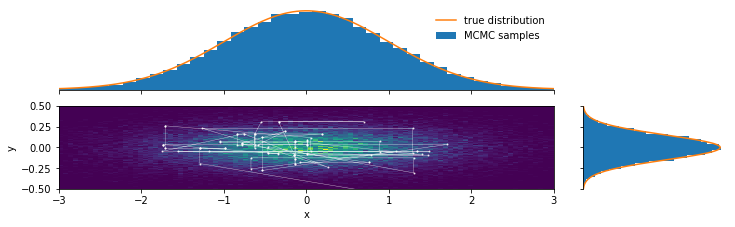

In [79]:
def plot_samples_2D(chain, path_length, burnin, ax, xlims=(-3, 3), ylims=(-0.5, 0.5)):
    chain = np.array(chain)
    bins = [np.linspace(xlims[0], xlims[1], 100), np.linspace(ylims[0], ylims[1], 100)]
    ax.hist2d(*chain[burnin:].T, bins=bins)
    ax.plot(*chain[:path_length].T, marker='o', c='w', lw=0.4, 
            markersize=1, alpha=0.75)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    
def plot_bivariate_samples(chain, burnin, pdf):
    fig = plt.figure(figsize=(12,7))
   
    ax_c = plt.subplot2grid((4, 4), (1, 0), rowspan=1, colspan=3)
    plot_samples_2D(chain, 100, burnin, ax_c)
    
    ax_t = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3, sharex=ax_c)
    plot_samples(chain[:,0], pdf.log_p_x, ax_t, normalize=False)
    plt.setp(ax_t.get_xticklabels(), visible=False)
    ax_t.set_yticks(())
    for spine in ('top', 'left', 'right'):
        ax_t.spines[spine].set_visible(False)

    ax_r = plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1, sharey=ax_c)
    plot_samples(chain[:,1], pdf.log_p_y, ax_r, orientation='horizontal',
                 normalize=False, legend=False)
    plt.setp(ax_r.get_yticklabels(), visible=False)
    ax_r.set_xticks(())
    for spine in ('top', 'bottom', 'right'):
        ax_r.spines[spine].set_visible(False)

    plt.show()
    
plot_bivariate_samples(chain, burnin=200, pdf=bivariate_normal)

In [80]:
mix_params = dict(mu1=1.0, mu2=2.0, sigma1=0.5, sigma2=0.2, w1=0.3, w2=0.7)

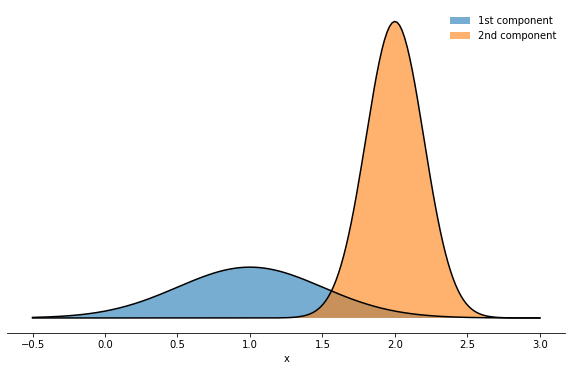

In [81]:
fig, ax = plt.subplots()
xspace = np.linspace(-0.5, 3, 200)

# densities of both components
first_component = [np.exp(log_gaussian(x, mix_params['mu1'], mix_params['sigma1']))
                   for x in xspace]
second_component = [np.exp(log_gaussian(x, mix_params['mu2'], mix_params['sigma2']))
                    for x in xspace]

# apply component weights
first_component = mix_params['w1'] * np.array(first_component)
second_component = mix_params['w2'] * np.array(second_component)

ax.plot(xspace, first_component, color='black')
ax.fill_between(xspace, first_component, alpha=0.6, label="1st component")
ax.plot(xspace, second_component, color='black')
ax.fill_between(xspace, second_component, alpha=0.6, label="2nd component")
ax.set_xlabel('x')
ax.set_yticks(())
ax.legend(frameon=False)
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
plt.show()

In [82]:
class GaussianMixture(object):
    
    def __init__(self, mu1, mu2, sigma1, sigma2, w1, w2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2
        self.w1, self.w2 = w1, w2
        
    def log_prob(self, x):
        return np.logaddexp(np.log(self.w1) + log_gaussian(x, self.mu1, self.sigma1),
                            np.log(self.w2) + log_gaussian(x, self.mu2, self.sigma2))
    
    def log_p_x_k(self, x, k):
        # logarithm of p(x|k)
        mu = (self.mu1, self.mu2)[k]
        sigma = (self.sigma1, self.sigma2)[k]
    
        return log_gaussian(x, mu, sigma)
    
    def p_k_x(self, k, x):
        # p(k|x) using Bayes' theorem
        mu = (self.mu1, self.mu2)[k]
        sigma = (self.sigma1, self.sigma2)[k]
        weight = (self.w1, self.w2)[k]
        log_normalization = self.log_prob(x)

        return np.exp(log_gaussian(x, mu, sigma) + np.log(weight) - log_normalization)

In [83]:
def sample_gibbs(old_state, mixture, stepsize):
    """Draws a single sample using the systematic Gibbs sampling
    transition kernel
    
    Arguments:
    - old_state: the old (two-dimensional) state of a Markov chain
                 (a list containing a float and an integer representing 
                 the initial mixture component)
    - mixture: an object representing a mixture of densities
               (in our case, an instance of GaussianMixture)
    - stepsize: a step size of type float 
    
    """
    x_old, k_old = old_state
    
    # for compatibility with sample_MH, change floats to one-dimensional
    # numpy arrays of length one
    x_old = np.array([x_old])
    
    # draw new x conditioned on k
    x_pdf = lambda x: mixture.log_p_x_k(x, k_old)
    accept, x_new = sample_MH(x_old, x_pdf, stepsize)
    
    # ... turn the one-dimensional numpy arrays of length one back
    # into floats
    x_new = x_new[0]
    
    # draw new k conditioned on x 
    k_probabilities = (mixture.p_k_x(0, x_new), mixture.p_k_x(1, x_new))
    jump_probability = k_probabilities[1 - k_old]
    k_new = np.random.choice((0,1), p=k_probabilities)
    
    return accept, jump_probability, (x_new, k_new)


def build_gibbs_chain(init, stepsize, n_total, mixture):
    """Builds a Markov chain by performing repeated transitions using
    the systematic Gibbs sampling transition kernel
    
    Arguments:
    - init: an initial (two-dimensional) state of a Markov chain
            (a list containing a one-dimensional numpy array
            of length one and an integer representing the initial
            mixture component)
    - stepsize: a step size of type float
    - n_total: the total length of the Markov chain
    - mixture: an object representing a mixture of densities
               (in our case, an instance of GaussianMixture)
    
    """
    init_x, init_k = init
    chain = [init]
    acceptances = []
    jump_probabilities = []
    
    for _ in range(n_total):
        accept, jump_probability, new_state = sample_gibbs(chain[-1], mixture, stepsize)
        chain.append(new_state)
        jump_probabilities.append(jump_probability)
        acceptances.append(accept)
    
    acceptance_rates = np.mean(acceptances)
    print("Acceptance rate: x: {:.3f}".format(acceptance_rates))
    print("Average probability to change mode: {}".format(np.mean(jump_probabilities)))
    
    return chain

mixture = GaussianMixture(**mix_params)
stepsize = 1.0
initial_state = [2.0, 1]
chain = build_gibbs_chain(initial_state, stepsize, 10000, mixture)
burnin = 1000
x_states = [state[0] for state in chain[burnin:]]

Acceptance rate: x: 0.631
Average probability to change mode: 0.08629295966662387


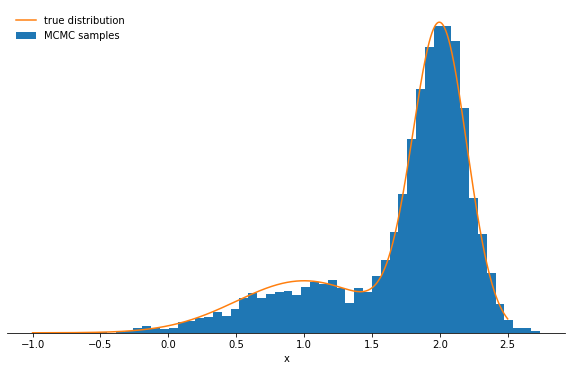

In [84]:
fig, ax = plt.subplots()
plot_samples(x_states, mixture.log_prob, ax, normalize=False, xlims=(-1,2.5))
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
ax.set_yticks(())
ax.set_xlabel('x')
plt.show()

In [85]:
mixture = GaussianMixture(mu1=-1.0, mu2=2.0, sigma1=0.5, sigma2=0.2, w1=0.3, w2=0.7)
stepsize = 1.0
initial_state = [2.0, 1]
chain = build_gibbs_chain(initial_state, stepsize, 100000, mixture)
burnin = 10000
x_states = [state[0] for state in chain[burnin:]]

Acceptance rate: x: 0.558
Average probability to change mode: 6.139534006013391e-06


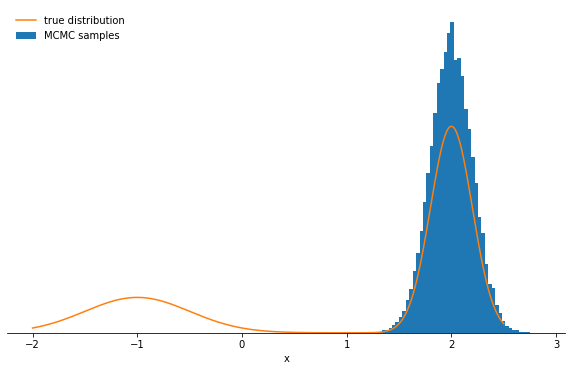

In [86]:
fig, ax = plt.subplots()
plot_samples(x_states, mixture.log_prob, ax, normalize=False, xlims=(-2,2.5))
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
ax.set_yticks(())
ax.set_xlabel('x')
plt.show()

## Hamiltonian Monte Carlo

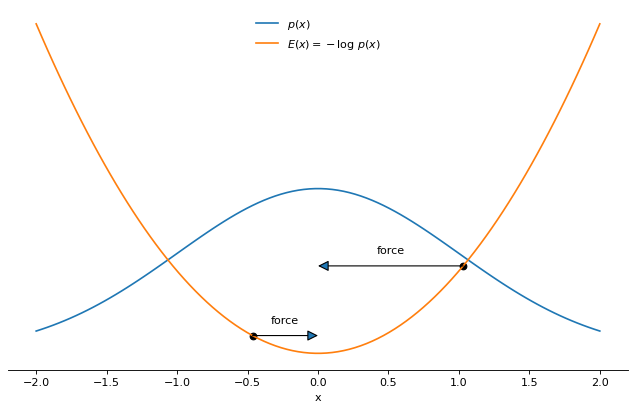

In [87]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

xspace = np.linspace(-2, 2, 100)
unnormalized_probs = np.exp(-0.5 * xspace ** 2)
energies = 0.5 * xspace ** 2

fig, ax = plt.subplots(dpi=80)
ax.plot(xspace, unnormalized_probs, label=r"$p(x)$")
ax.plot(xspace, energies, label=r"$E(x)=-\log\ p(x)$")
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
x_index1 = 75
ax.scatter((xspace[x_index1],), (energies[x_index1],), color="k")
a_start1 = np.array((xspace[x_index1], energies[x_index1]))
a_end1 = np.array((xspace[x_index1] - xspace[x_index1], energies[x_index1]))
ax.annotate("",a_end1, a_start1, arrowprops=prop)
text_pos1 = (a_start1[0] + 0.5 * (a_end1[0] - a_start1[0]), a_end1[1] + 0.075)
ax.text(*text_pos1, r"force", horizontalalignment="center")

x_index2 = 38
ax.scatter((xspace[x_index2],), (energies[x_index2],), color="k")
a_start2 = np.array((xspace[x_index2], energies[x_index2]))
a_end2 = np.array((xspace[x_index2] - xspace[x_index2], energies[x_index2]))
ax.annotate("",a_end2, a_start2, arrowprops=prop)
text_pos2 = (a_start2[0] + 0.5 * (a_end2[0] - a_start2[0]), a_end2[1] + 0.075, )
ax.text(*text_pos2, r"force", horizontalalignment="center")

ax.set_xlabel("x")
ax.set_yticks(())
for spine in ('top', 'right', 'left'):
    ax.spines[spine].set_visible(False)
ax.legend(frameon=False)
plt.show()

In [88]:
def leapfrog(x, v, gradient, timestep, trajectory_length):
    v -= 0.5 * timestep * gradient(x)
    for _ in range(trajectory_length - 1):
        x += timestep * v
        v -= timestep * gradient(x)
    x += timestep * v
    v -= 0.5 * timestep * gradient(x)

    return x, v

In [89]:
def sample_HMC(x_old, log_prob, log_prob_gradient, timestep, trajectory_length):
    # switch to physics mode!
    def E(x): return -log_prob(x)
    def gradient(x): return -log_prob_gradient(x)
    def K(v): return 0.5 * np.sum(v ** 2)
    def H(x, v): return K(v) + E(x)

    # Metropolis acceptance probability, implemented in "logarithmic space"
    # for numerical stability:
    def log_p_acc(x_new, v_new, x_old, v_old):
        return min(0, -(H(x_new, v_new) - H(x_old, v_old)))

    # give a random kick to particle by drawing its momentum from p(v)
    v_old = np.random.normal(size=x_old.shape)

    # approximately calculate position x_new and momentum v_new after
    # time trajectory_length  * timestep
    x_new, v_new = leapfrog(x_old.copy(), v_old.copy(), gradient, 
                            timestep, trajectory_length)

    # accept / reject based on Metropolis criterion
    accept = np.log(np.random.random()) < log_p_acc(x_new, v_new, x_old, v_old)

    # we consider only the position x (meaning, we marginalize out v)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

In [90]:
def build_HMC_chain(init, timestep, trajectory_length, n_total, log_prob, gradient):
    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_HMC(chain[-1].copy(), log_prob, gradient,
                                   timestep, trajectory_length)
        chain.append(state)
        n_accepted += accept

    acceptance_rate = n_accepted / float(n_total)

    return chain, acceptance_rate

In [91]:
def log_prob(x): return -0.5 * np.sum(x ** 2)

In [92]:
def log_prob_gradient(x): return -x

In [93]:
chain, acceptance_rate = build_HMC_chain(np.array([5.0, 1.0]), 1.5, 10, 10000,
                                         log_prob, log_prob_gradient)
print("Acceptance rate: {:.3f}".format(acceptance_rate))

Acceptance rate: 0.622


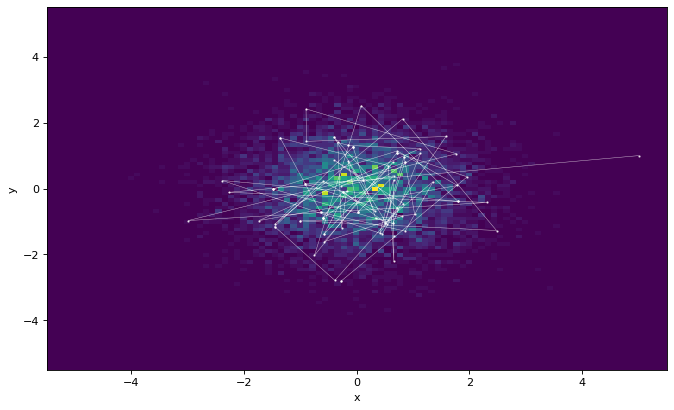

In [94]:
fig, ax = plt.subplots(dpi=80)
plot_samples_2D(chain, 100, 200, ax, xlims=(-5.5, 5.5), ylims=(-5.5, 5.5))
plt.show()

In [95]:
chain, acceptance_rate = build_MH_chain(np.array([5.0, 1.0]), 2.6, 10000, log_prob)
print("Acceptance rate: {:.3f}".format(acceptance_rate))

Acceptance rate: 0.623


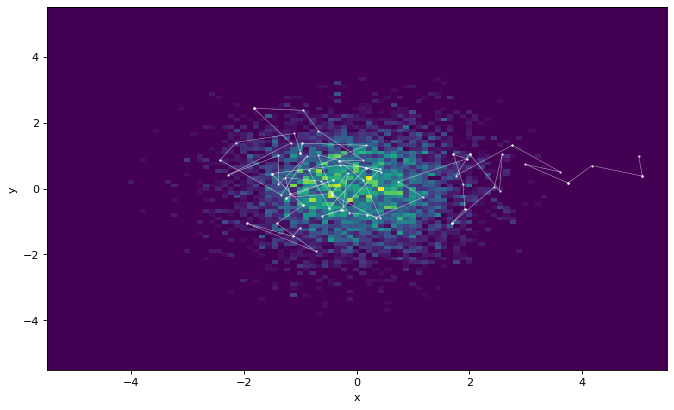

In [96]:
fig, ax = plt.subplots(dpi=80)
plot_samples_2D(chain, 100, 200, ax, xlims=(-5.5, 5.5), ylims=(-5.5, 5.5))
plt.show()

##  Replica Exchange

In [97]:
mix_params = dict(mu1=-1.5, mu2=2.0, sigma1=0.5, sigma2=0.2, w1=0.3, w2=0.7)
mixture = GaussianMixture(**mix_params)
temperatures = [0.1, 0.4, 0.6, 0.8, 1.0]

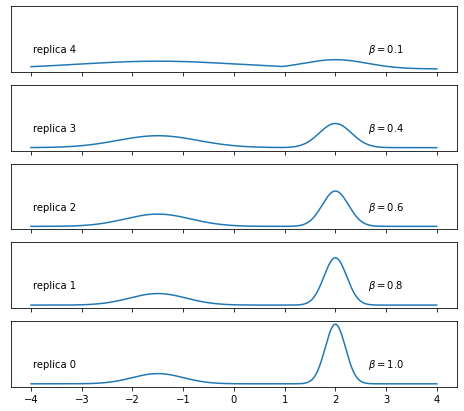

In [98]:
from scipy.integrate import quad

def plot_tempered_distributions(log_prob, temperatures, axes, xlim=(-4, 4)):
    xspace = np.linspace(*xlim, 1000)
    for i, (temp, ax) in enumerate(zip(temperatures, axes)):
        pdf = lambda x: np.exp(temp * log_prob(x))
        Z = quad(pdf, -1000, 1000)[0]
        ax.plot(xspace, np.array(list(map(pdf, xspace))) / Z)
        ax.text(0.8, 0.3, r'$\beta={}$'.format(temp), transform=ax.transAxes)
        ax.text(0.05, 0.3, 'replica {}'.format(len(temperatures) - i - 1), 
                transform=ax.transAxes)
        ax.set_yticks(())
    plt.show()
    
fig, axes = plt.subplots(len(temperatures), 1, sharex=True, sharey=True,
                        figsize=(8, 7))
plot_tempered_distributions(mixture.log_prob, temperatures, axes)
plt.show()

In [99]:
def handle_left_border(leftmost_old_state, leftmost_temperature, 
                       leftmost_stepsize, log_prob, new_multistate):
    accepted, state = sample_MH(leftmost_old_state, 
                                lambda x: leftmost_temperature * log_prob(x), 
                                leftmost_stepsize)
    new_multistate = [state] + new_multistate
    return new_multistate, accepted


def handle_right_border(rightmost_old_state, rightmost_temperature, 
                        rightmost_stepsize, log_prob, new_multistate):
    accepted, state = sample_MH(rightmost_old_state, 
                                lambda x: rightmost_temperature * log_prob(x),
                                rightmost_stepsize)
    new_multistate = new_multistate + [state]
    return new_multistate, accepted
    
    
def build_RE_chain(init, stepsizes, n_total, temperatures, swap_interval, log_prob):

    from itertools import cycle

    n_replicas = len(temperatures)

    # a bunch of arrays in which we will store how many
    # Metropolis-Hastings / swap moves were accepted
    # and how many there were performed in total

    accepted_MH_moves = np.zeros(n_replicas)
    total_MH_moves = np.zeros(n_replicas)
    accepted_swap_moves = np.zeros(n_replicas - 1)
    total_swap_moves = np.zeros(n_replicas - 1)

    cycler = cycle((True, False))
    chain = [init]
    for k in range(n_total):
        new_multistate = []
        if k > 0 and k % swap_interval == 0:
            # perform RE swap
            # First, determine the swap partners
            if next(cycler):
                # swap (0,1), (2,3), ...
                partners = [(j-1, j) for j in range(1, n_replicas, 2)]
            else:
                # swap (1,2), (3,4), ...
                partners = [(j-1, j) for j in range(2, len(temperatures), 2)]
            # Now, for each pair of replicas, attempt an exchange
            for (i,j) in partners:
                bi, bj = temperatures[i], temperatures[j]
                lpi, lpj = log_prob(chain[-1][i]), log_prob(chain[-1][j])
                log_p_acc = min(0, bi * lpj - bi * lpi + bj * lpi - bj * lpj)
                if np.log(np.random.uniform()) < log_p_acc:
                    new_multistate += [chain[-1][j], chain[-1][i]]
                    accepted_swap_moves[i] += 1
                else:
                    new_multistate += [chain[-1][i], chain[-1][j]]
                total_swap_moves[i] += 1
            # We might have border cases: if left- / rightmost replicas don't participate
            # in swaps, have them draw a sample
            if partners[0][0] != 0:
                new_multistate, accepted = handle_left_border(chain[-1][0], temperatures[0],
                                                              stepsizes[0], log_prob,
                                                              new_multistate)
                accepted_MH_moves[0] += accepted
                total_MH_moves[0] += 1
            if partners[-1][1] != len(temperatures) - 1:
                new_multistate, accepted = handle_right_border(chain[-1][-1], temperatures[-1],
                                                               stepsizes[-1], log_prob,
                                                               new_multistate)
                accepted_MH_moves[-1] += accepted
                total_MH_moves[-1] += 1
        else:
            # perform sampling in single chains
            for j, temp in enumerate(temperatures):
                accepted, state = sample_MH(chain[-1][j], lambda x: temp * log_prob(x), stepsizes[j])
                accepted_MH_moves[j] += accepted
                total_MH_moves[j] += 1
                new_multistate.append(state)
        chain.append(new_multistate)

    # calculate acceptance rates
    MH_acceptance_rates = accepted_MH_moves / total_MH_moves
    # safe division in case of zero total swap moves
    swap_acceptance_rates = np.divide(accepted_swap_moves, total_swap_moves,
                                      out=np.zeros(n_replicas - 1), where=total_swap_moves != 0)

    return MH_acceptance_rates, swap_acceptance_rates, np.array(chain)

In [100]:
stepsizes = [2.75, 2.5, 2.0, 1.75, 1.6]

In [101]:
def print_MH_acceptance_rates(mh_acceptance_rates):
    print("MH acceptance rates: " + "".join(["{}: {:.3f} ".format(i, x)
                                             for i, x in enumerate(mh_acceptance_rates)]))


mh_acc_rates, swap_acc_rates, chains = build_RE_chain(np.random.uniform(low=-3, high=3,
                                                                        size=len(temperatures)),
                                                      stepsizes, 10000, temperatures, 500000000,
                                                      mixture.log_prob)
print_MH_acceptance_rates(mh_acc_rates)

MH acceptance rates: 0: 0.790 1: 0.551 2: 0.415 3: 0.552 4: 0.705 


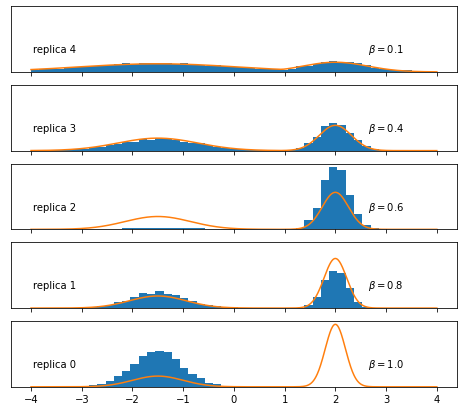

In [102]:
def plot_RE_samples(chains, axes, bins=np.linspace(-4, 4, 50)):
    for i, (chain, ax) in enumerate(zip(chains, axes)):
        ax.hist(chain, bins, density=True, label="MCMC samples")
        
fig, axes = plt.subplots(len(temperatures), 1, sharex=True, sharey=True,
                         figsize=(8, 7))
plot_RE_samples(chains[100:].T, axes)
plot_tempered_distributions(mixture.log_prob, temperatures, axes)
plt.show()

In [103]:
init = np.random.uniform(low=-4, high=4, size=len(temperatures))
mh_acc_rates, swap_acc_rates, chains = build_RE_chain(init, stepsizes,
                                                      10000, temperatures, 5,
                                                      mixture.log_prob)
print_MH_acceptance_rates(mh_acc_rates)
swap_rate_string = "".join(["{}<->{}: {:.3f}, ".format(i, i+1, x)
                            for i, x in enumerate(swap_acc_rates)])[:-2]
print("Swap acceptance rates:", swap_rate_string)

MH acceptance rates: 0: 0.797 1: 0.552 2: 0.539 3: 0.499 4: 0.466 
Swap acceptance rates: 0<->1: 0.585, 1<->2: 0.846, 2<->3: 0.829, 3<->4: 0.876


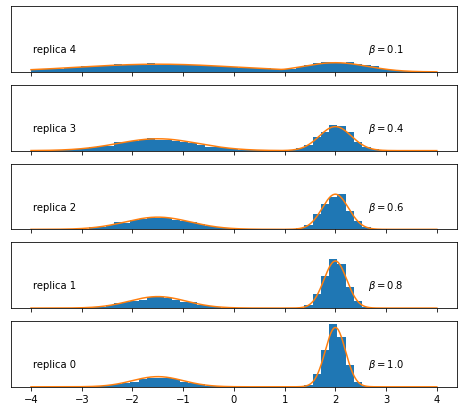

In [104]:
fig, axes = plt.subplots(len(temperatures), 1, sharex=True, sharey=True,
                        figsize=(8, 7))
plot_RE_samples(chains[100:].T, axes)
plot_tempered_distributions(mixture.log_prob, temperatures, axes)
plt.show()

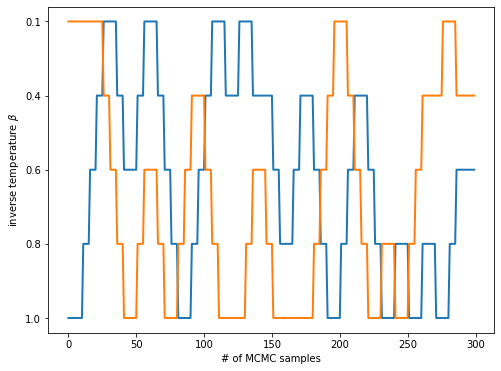

In [105]:
# Detect swaps. This method works only under the assumption that
# when performing local MCMC moves, starting from two different 
# initial states, you cannot end up with the same state
swaps = {}
# for each pair of chains...
for i in range(len(chains) - 1):
    # shift one chain by one state to the left.
    # Where states from both chains match up, a successful exchange
    # was performed
    matches = np.where(chains[i, :-1] == chains[i+1, 1:])[0]
    if len(matches) > 0:
        swaps[i] = matches


# Reconstruct trajectories of single states through the temperature
# ladder
def reconstruct_trajectory(start_index, chains):
    res = []
    current_ens = start_index
    for i in range(len(chains)):
        res.append(current_ens)
        if i in swaps:
            if current_ens in swaps[i]:
                current_ens += 1
            elif current_ens in swaps[i] + 1:
                current_ens -= 1

    return np.array(res)


def plot_state_trajectories(trajectories, ax, max_samples=300):
    for trajectory in trajectories:
        ax.plot(-trajectory[:max_samples] - 1, lw=2)
    ax.set_xlabel("# of MCMC samples")
    ax.set_ylabel(r"inverse temperature $\beta$")
    # make order of temperatures appear as above - whatever it takes...
    ax.set_yticks(range(-len(temperatures), 0))
    ax.set_yticklabels(temperatures[::-1])
    

# which states to follow
start_state_indices = (4, 0)

fig, ax = plt.subplots(figsize=(8, 6))
trajectories = np.array([reconstruct_trajectory(i, chains) 
                         for i in start_state_indices])
plot_state_trajectories(trajectories, ax)
plt.show()